In [12]:
import pandas as pd
import shapely
import simpy
from numpy import random
import gurobipy

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
from openclsim.io import get_activity_resources, get_activity_log, get_activities, get_concepts
from openclsim.io import get_tree_as_list, get_ranges_dataframe

In [13]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.Log,
    ),
    {},
)

In [14]:
def run(nr_tshd, nr_barge, total_amount):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    
    #create site objects
    location_berth = shapely.geometry.Point(4.18055556, 52.18664444)
    data_berth = {"env": my_env,
                      "name": "berth",
                      "geometry": location_berth,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":2}
    berth = Site(**data_berth)

    location_dump = shapely.geometry.Point(4.25222222, 52.11428333)
    data_dump = {"env": my_env,
                    "name": "dump",
                    "geometry": location_dump,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":2}
    dump = Site(**data_dump)
    
    #create vessel objects
    vessels = {}
    
    for i in range (nr_tshd):
        vessels[f"tshd{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"tshd{i}",
            geometry=location_dump,
            capacity=2000,
            compute_v=lambda x: 10
        )
    tshd = TransportProcessingResource(
        env=my_env,
        name=f"tshd{i}",
        geometry=location_dump,
        capacity=2000,
        compute_v=lambda x: 10
    )
    for i in range (nr_barge):
        vessels[f"barge{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"barge{i}",
            geometry=location_dump,
            capacity=4000,
            compute_v=lambda x: 7
        )
    backhoe = TransportProcessingResource(
        env=my_env,
        name="backhoe",
        geometry=location_berth,
        capacity=0,
        compute_v=lambda x: 0
    )
    
    vessels['tshd'] = tshd
    vessels['backhoe'] = backhoe
       
    activities_tshd = {}
    
    for i in range (nr_tshd):
        requested_resources={}

        
        subprocesses_tshd = [
        model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty: "+vessels[f"tshd{i}"].name,
                        registry=registry,
                        mover=vessels[f"tshd{i}"],
                        destination=berth,
                        duration=1*3600,
                    ),
        model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading: "+vessels[f"tshd{i}"].name,
                        registry=registry,
                        processor=vessels[f"tshd{i}"],
                        origin=berth,
                        destination=vessels[f"tshd{i}"],
                        amount=2000,
                        duration=2*3600,
                        requested_resources=requested_resources,
                    ),
        model.MoveActivity(
                        env=my_env,
                        name=f"sailing full: "+vessels[f"tshd{i}"].name,
                        registry=registry,
                        mover=vessels[f"tshd{i}"],
                        destination=dump,
                        duration=1.5*3600,
                    ),
        model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading: "+vessels[f"tshd{i}"].name,
                        registry=registry,
                        processor=vessels[f"tshd{i}"],
                        origin=vessels[f"tshd{i}"],
                        destination=dump,
                        amount=2000,
                        duration=0.5*3600,
                        requested_resources=requested_resources,
                    )
        ]
        
        activities_tshd[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle_tshd{i}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle_tshd{i}",
                registry=registry,
                sub_processes= subprocesses_tshd
            )],
             condition_event=[{"type": "container",
                              "concept": berth,
                              "state": "empty",
                              "id_":"default_reservations"}
                             ]
        )


    
    activities_backhoe_barge = {}

    for i in range (nr_barge):
        requested_resources={}

        subprocesses_backhoe_barge = [
        model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty:"+vessels[f"barge{i}"].name,
                        registry=registry,
                        mover=vessels[f"barge{i}"],
                        destination=berth,
                        duration=1*3600,
                    ),
        model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading:"+vessels[f"barge{i}"].name,
                        registry=registry,
                        processor=backhoe,
                        origin=berth,
                        destination=vessels[f"barge{i}"],
                        amount=4000,
                        duration=4*3600,
                        requested_resources=requested_resources,
                    ),
        model.MoveActivity(
                        env=my_env,
                        name=f"sailing full:"+vessels[f"barge{i}"].name,
                        registry=registry,
                        mover=vessels[f"barge{i}"],
                        destination=dump,
                        duration=1.5*3600,
                    ),
        model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading: "+vessels[f"barge{i}"].name,
                        registry=registry,
                        processor=vessels[f"barge{i}"],
                        origin=vessels[f"barge{i}"],
                        destination=dump,
                        amount=4000,
                        duration=0.5*3600,
                        requested_resources=requested_resources,
                    )
        ]
         
        activities_backhoe_barge[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle_barge{i}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle_barge{i}",
                registry=registry,
                sub_processes= subprocesses_backhoe_barge,
            )],
             condition_event=[{"type": "container",
                              "concept": berth,
                              "state": "empty",
                              "id_":"default_reservations"}
                             ]
        )        
                           
    model.register_processes([*activities_tshd.values(), *activities_backhoe_barge.values()])
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities_tshd": activities_tshd,
        "activities_backhoe_barge": activities_backhoe_barge,
        "berth":berth,
        "dump":dump,
    }

In [15]:
nr_barges = 2
nr_tshds = 2
res = run(nr_barges, nr_tshds , 30000)
vessels = res['vessels']
activities_backhoe_barge = res['activities_backhoe_barge']
activities_tshd = res['activities_tshd']
berth = res['berth']
dump = res['dump']

In [16]:
display(plot.get_log_dataframe(berth, [*activities_tshd.values(), *activities_backhoe_barge.values()]))

,Activity,Timestamp,ActivityState,container level,geometry
0,loading: tshd0,1970-01-01 01:00:00,START,30000,POINT (4.18055556 52.18664444)
1,loading: tshd1,1970-01-01 01:00:00,START,28000,POINT (4.18055556 52.18664444)
2,loading: tshd0,1970-01-01 03:00:00,STOP,26000,POINT (4.18055556 52.18664444)
3,loading: tshd1,1970-01-01 03:00:00,STOP,26000,POINT (4.18055556 52.18664444)
4,loading:barge0,1970-01-01 03:00:00,START,26000,POINT (4.18055556 52.18664444)
5,loading: tshd0,1970-01-01 06:00:00,START,22000,POINT (4.18055556 52.18664444)
6,loading:barge0,1970-01-01 07:00:00,STOP,20000,POINT (4.18055556 52.18664444)
7,loading: tshd1,1970-01-01 07:00:00,START,20000,POINT (4.18055556 52.18664444)
8,loading: tshd0,1970-01-01 08:00:00,STOP,18000,POINT (4.18055556 52.18664444)
9,loading:barge1,1970-01-01 08:00:00,START,18000,POINT (4.18055556 52.18664444)


In [17]:
fig = plot.get_gantt_chart([*vessels.values()], id_map=[*activities_tshd.values(), *activities_backhoe_barge.values()])

In [18]:
fig = plot.get_gantt_chart(
    [berth, dump],
    id_map=[*activities_tshd.values(), *activities_backhoe_barge.values()]
)

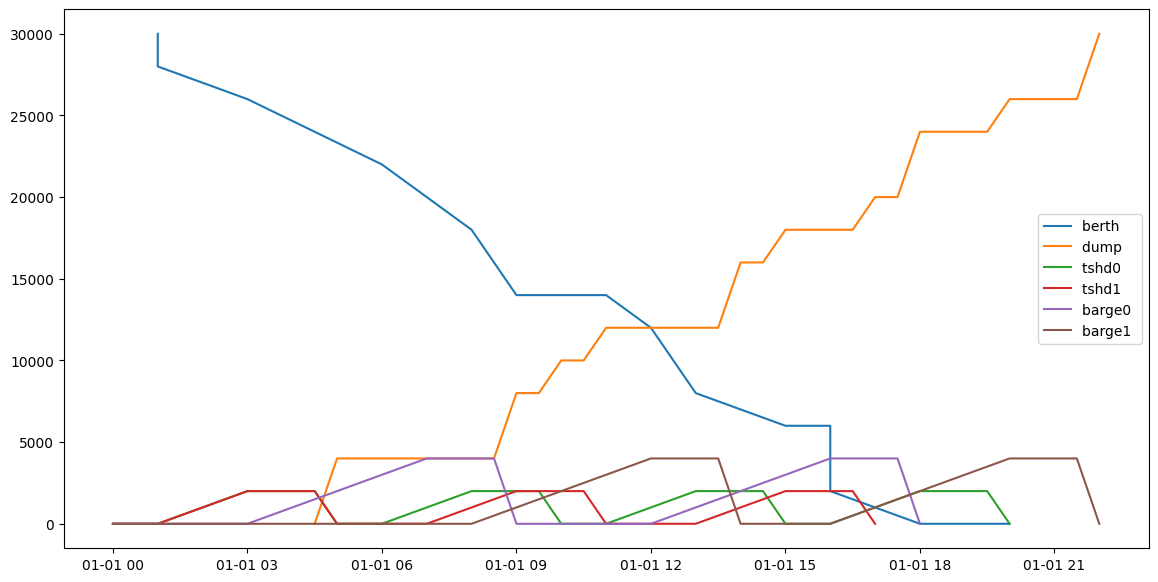

In [19]:
fig = plot.get_step_chart([berth, dump, *vessels.values()])

### Task

Determine the total energy consumption of the maintenance dredging processes for different scenarios

Draw a graph that compares the energy consumption of each scenario and the duration of doing each job.

In [20]:
from prettytable import PrettyTable

# Create a PrettyTable object
table = PrettyTable()

# Define column names
table.field_names = ["fuel_type", "emission_factor"]

# Add rows to the table
table.add_row(["Diesel", "1.5"])
table.add_row(["MGO", "2.0"])
table.add_row(["LNG", "1"])

# Print the table
print(table)


+-----------+-----------------+
| fuel_type | emission_factor |
+-----------+-----------------+
|   Diesel  |       1.5       |
|    MGO    |       2.0       |
|    LNG    |        1        |
+-----------+-----------------+


In [21]:
barge_empty = 1000 # kW
barge_full = 2500 # kW
barge_loading = 1000 # kW
barge_unloading = 2500 # kW
barge_WAIT = 20 # kW

hopper_empty = 2000 # kW
hopper_full = 5000 # kW
hopper_loading = 10000 # kW
hopper_unloading = 6000 # kW
hopper_WAIT = 100 # kW

backhoe_loading = 15000
backhoe_WAIT = 500

backhoe_name = 'backhoe'
barge_names    = ['barge I','barge II','barge III']
tshd_names    = ['tshd I','tshd II']


vessel_specs = pd.DataFrame.from_dict(
       {'rates [€/day]':{'barge I':5000,'barge II':5000,'barge III':5000,
                        'tshd I':15000, 'tshd II': 15000,
                        'backhoe':25000}, # EUR/day
   'sailing empty [kW]':{'barge I':barge_empty,'barge II':barge_empty,'barge III':barge_empty,
                        'tshd I':hopper_empty, 'tshd II': hopper_empty,
                        'backhoe':0},
         'loading [kW]':{'barge I':barge_loading, 'barge II':barge_loading,'barge III':barge_loading,
                         'tshd I':hopper_loading, 'tshd II': hopper_loading,
                         'backhoe':backhoe_loading},
    'sailing full [kW]':{'barge I':barge_full,'barge II':barge_full,'barge III':barge_full,
                         'tshd I':hopper_full, 'tshd II': hopper_full,
                         'backhoe':0},
       'unloading [kW]':{'barge I':barge_unloading,'barge II':barge_unloading,'barge III':barge_unloading,
                         'tshd I':hopper_unloading, 'tshd II': hopper_unloading,
                         'backhoe':0},
            'WAIT [kW]':{'barge I':barge_WAIT,'barge II':barge_WAIT,'barge III':barge_WAIT,
                         'tshd I':hopper_WAIT, 'tshd II': hopper_WAIT,
                         'backhoe':backhoe_WAIT},
          'vessel_type':{'barge I':'barge','barge II':'barge','barge III':'barge',
                         'tshd I':'TSHD', 'tshd II': 'TSHD',
                         'backhoe':'BHD'},
      'fuel_type':{'barge I':'Diesel','barge II':'Diesel','barge III':'Diesel',
                         'tshd I':'LNG', 'tshd II': 'LNG',
                         'backhoe':'MGO'},
})

vessel_specs.index.name = 'vessel_name' 
vessel_specs.to_csv('vessel_specs.csv', index=True)
vessel_specs = pd.read_csv('vessel_specs.csv', index_col='vessel_name')
vessel_specs

,rates [€/day],sailing empty [kW],loading [kW],sailing full [kW],unloading [kW],WAIT [kW],vessel_type,fuel_type
vessel_name,,,,,,,,
barge I,5000,1000,1000,2500,2500,20,barge,Diesel
barge II,5000,1000,1000,2500,2500,20,barge,Diesel
barge III,5000,1000,1000,2500,2500,20,barge,Diesel
tshd I,15000,2000,10000,5000,6000,100,TSHD,LNG
tshd II,15000,2000,10000,5000,6000,100,TSHD,LNG
backhoe,25000,0,15000,0,0,500,BHD,MGO


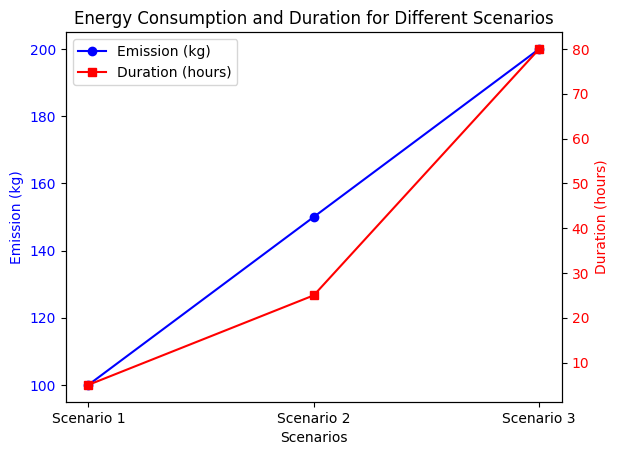

In [22]:
import matplotlib.pyplot as plt

# Data
scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3']
emission = [100, 150, 200]  # Energy consumption in kWh
duration = [5, 25, 80]  # Duration in hours

# Create subplots
fig, ax = plt.subplots()

# Plot energy consumption
ax.plot(scenarios, emission, marker='o', color='b', label='Emission (kg)')
ax.set_ylabel('Emission (kg)', color='b')
ax.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for duration
ax2 = ax.twinx()
ax2.plot(scenarios, duration, marker='s', color='r', label='Duration (hours)')
ax2.set_ylabel('Duration (hours)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and labels
plt.title('Energy Consumption and Duration for Different Scenarios')
ax.set_xlabel('Scenarios')

# Add legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()
